# Automatic Differentiation

> The **backpropagation** algorithm was originally introduced in the 1970s, but its importance wasn't fully appreciated until a famous 1986 paper by David Rumelhart, Geoffrey Hinton, and Ronald Williams. (Michael Nielsen in "Neural Networks and Deep Learning", http://neuralnetworksanddeeplearning.com/chap2.html).

> **Backpropagation** is the key algorithm that makes training deep models computationally tractable. For modern neural networks, it can make training with gradient descent as much as ten million times faster, relative to a naive implementation. That’s the difference between a model taking a week to train and taking 200,000 years. (Christopher Olah, 2016)

We have seen that in order to optimize our models we need to compute the derivative of the loss function with respect to all model paramaters. 

The computation of derivatives in computer models is addressed by four main methods: 

+ manually working out derivatives and coding the result (as in the original paper describing backpropagation); 

![alt text](../imgs/back.png)


+ numerical differentiation (using finite difference approximations); 
+ symbolic differentiation (using expression manipulation in software, such as Sympy); 
+ and automatic differentiation (AD).

**Automatic differentiation** (AD) works by systematically applying the **chain rule** of differential calculus at the elementary operator level.

Let $ y = f(g(x)) $ our target function. In its basic form, the chain rule states:

$$ \frac{\partial y}{\partial x} = \frac{\partial y}{\partial g} \frac{\partial g}{\partial x} $$

or, if there are more than one variable $g_i$ in-between $y$ and $x$ (f.e. if $f$ is a two dimensional function such as $f(g_1(x), g_2(x))$), then:

$$ \frac{\partial y}{\partial x} = \sum_i \frac{\partial y}{\partial g_i} \frac{\partial g_i}{\partial x} $$

> See https://www.math.hmc.edu/calculus/tutorials/multichainrule/

AD allows the accurate evaluation of derivatives at machine precision, with only a small constant factor of overhead.

In its most basic description, AD relies on the fact that all numerical computations
are ultimately compositions of a finite set of elementary operations for which derivatives are known.

For example, let's consider this function:

$$y = f(x_1, x_2) = \ln(x_1) + x_1 x_2 − sin(x_2)$$

The evaluation of this expression can be described by using intermediate variables $v_i$ such that:

+ variables $v_{i−n} = x_i$, $i = 1,\dots, n$ are the input variables,
+ variables $v_i$, $i = 1,\dots, l$ are the working variables, and
+ variables $y_{m−i} = v_{l−i}$, $i = m − 1, \dots, 0$ are the output variables.

Let's write the forward evaluation trace, based on elementary operations, at $(x_1, x_2) = (2,5)$:

+ $v_{-1} = x_1 = 2$
+ $v_0 = x_2 = 5$
+ $v_1 = \ln v_{-1} = \ln 2 = 0.693$
+ $v_2 = v_{-1} \times v_0 = 2 \times 5 = 10$
+ $v_3 = sin(v_0) = sin(5) = -0.959$
+ $v_4 = v_1+ v_2 = 0.693 + 10 = 10.693$
+ $v_5 = v_4 - v_3 = 10.693 + 0.959 = 11.652$
+ $y = v_5 = 11.652$

It is interesting to note that this trace can be represented by a graph that can be automatically derived from $f(x_1, x_2)$.

![alt text](../imgs/t7.png)


### Forward-mode differentiation 

Given a function made up of several nested function calls, there are several ways to compute its derivative.

For example, given $L(x) = f(g(h(x)))$, the chain rule says that its gradient is:

$$ \frac{\partial L}{\partial x} = \frac{\partial f}{\partial g} \times \frac{\partial g}{\partial h} \times \frac{\partial h}{\partial x}$$

If we evaluate this product from right-to-left: $\frac{\partial F}{\partial G} \times (\frac{\partial G}{\partial H} \times \frac{\partial H}{\partial x})$, the same order as the computations themselves were performed, this is called **forward-mode differentiation**.

For computing the derivative of $f$ with respect to $x_1$ we start by associating with each intermediate variable $v_i$ a derivative: $\partial v_i = \frac{\partial v_i}{\partial x_1}$.

Then we apply the chain rule to each elementary operation:

+ $\partial v_{-1} = \frac{\partial x_1}{\partial x_1} = 1$
+ $\partial v_0 = \frac{\partial x_2}{\partial x_1} = 0$
+ $\partial v_1 = \frac{\partial \ln(v_{-1})}{\partial v_{-1}} \partial v_{-1}= 1 / 2 \times 1 = 0.5$
+ $\partial v_2 = \frac{\partial (v_{-1} \times v_0)
}{\partial v_{-1}} \partial v_{-1} + 
\frac{\partial (v_{-1} \times v_0)
}{\partial v_{0}} \partial v_{0}
= 5 \times 1 + 2 \times 0 = 5$
+ $\partial v_3 = \frac{\partial sin(v_0)}{\partial v_0} \partial v_0 = cos(5) \times 0$
+ $\partial v_4 = \partial v_1+ \partial v_2 = 0.5 + 5$
+ $\partial v_5 = \partial v_4 - \partial v_3 = 5.5 - 0$
+ $\partial y = \partial v_5 = 5.5$

At the end we have the derivative of $f$ with respect to $x_1$ at $(2,5)$.

It is important to note that this computation can be locally performed at each node $v_i$ of the graph if we: 
+ follow the right evaluation order 
+ we store at each node its corresponding value from the forward evaluation trace
+ we know how to compute its derivative with respect to its parent nodes.

For example, at node $v_2$:

![alt text](../imgs/t8.png)

AD relies on the fact that all numerical computations are ultimately compositions of a finite set of elementary operations for which **derivatives are known**.

We have seen **forward accumulation** AD. Forward accumulation is efficient for functions $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $n << m$ (only $O(n)$ sweeps are necessary). For cases $n >> m$ a different technique is needed.

### Reverse-mode differentiation 


Luckily, we can also propagate derivatives backward from a given output. This is **reverse accumulation** AD. 
If we evaluate this product from left-to-right: $(\frac{\partial f}{\partial g} \times \frac{\partial g}{\partial h}) \times \frac{\partial h}{\partial x}$, this is called **reverse-mode differentiation**.

Reverse pass starts at the end (i.e. $\frac{\partial y}{\partial y} = 1$) and propagates backward to all dependencies. In our case, $y$ will correspond to the components of the loss function.

Here we have:

+ $\partial y  = 1 $
+ $\partial v_5 = 1 $
+ $\partial v_{4} = \partial v_{5} \frac{\partial v_5}{\partial v_{4}} = 1 \times 1 = 1$
+ $\partial v_{3} = \bar v_{5} \frac{\partial v_5}{\partial v_{3}} = \partial v_5 \times -1 = -1$
+ $\partial v_{1} = \partial v_{4} \frac{\partial v_4}{\partial v_{1}} = \partial v_4 \times 1  = 1$
+ $\partial v_{2} = \partial v_{4} \frac{\partial v_4}{\partial v_{2}} = \partial v_4 \times 1  = 1$
+ $\partial v_{0} = \partial v_{3} \frac{\partial v_3}{\partial v_{0}} = \partial v_3 \times \cos v_0  = -0.284$
+ $\partial v_{-1} = \partial v_{2} \frac{\partial v_2}{\partial v_{-1}} = \partial v_2 \times v_0 = 5   $
+ $\partial v_0 = \partial v_0 + \partial v_2 \frac{\partial v_2}{\partial v_{0}} = \partial v_0 + \partial v_2 \times v_{-1} = 1.716$
+ $\partial v_{-1} = \partial v_{-1} + \partial v_{1} \frac{\partial v_1}{\partial v_{-1}} = \partial v_{-1} + \partial v_{1}/v_{-1} = 5.5$
+ $\partial x_{2} = \partial v_{0} = 1.716$
+ $\partial x_{1} = \partial v_{-1} = 5.5$

This is a two-stage process. In the first stage the original function code is run forward, populating $v_i$ variables. In the second stage, derivatives are calculated by propagating in reverse, from the outputs to the inputs.

The most important property of reverse accumulation AD is that it is cheaper than forward accumulation AD for funtions with a high number of input variables. In our case, $f : \mathbb{R}^n \rightarrow \mathbb{R}$, only one application of the reverse mode is sufficient to compute the full gradient of the function $\nabla f = \big( \frac{\partial y}{\partial x_1}, \dots ,\frac{\partial y}{\partial x_n} \big)$.  

Autograd is a Python module (with only one function) that implements automatic differentiation.

Autograd can automatically differentiate Python and Numpy code:

+ It can handle most of Python’s features, including loops, if statements, recursion and closures.
+ Autograd allows you to compute gradients of many types of data structures (Any nested combination of lists, tuples, arrays, or dicts).
+ It can also compute higher-order derivatives.
+ Uses reverse-mode differentiation (backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued or vector-valued arguments.
+ You can easily implement your custim gradients (good for speed, numerical stability, non-compliant code, etc).

In [1]:
import autograd.numpy as np
from autograd import grad

x = np.array([2, 5], dtype=float)

def test(x):
    return np.log(x[0]) + x[0]*x[1] - np.sin(x[1])

grad_test = grad(test)
print("({:.2f},{:.2f})".format(grad_test(x)[0],grad_test(x)[1]))

(5.50,1.72)


Then, logistic regression model fitting

$$  f(x) = \frac{1}{1 + \exp^{-(w_0 + w_1 x)}} $$

can be implemented in this way:

In [2]:
import autograd.numpy as np
from autograd import grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    label_probabilities = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(label_probabilities))

def optimize(inputs, targets, training_loss):
    # Optimize weights using gradient descent.
    gradient_loss = grad(training_loss)
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in np.arange(100):
        weights -= gradient_loss(weights, inputs, targets) * 0.01
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

# Build a toy dataset.
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

weights = optimize(inputs, targets, training_loss)
print("Weights:", weights)

Initial loss: 2.772588722239781
Final loss: 1.0672706757870165
Weights: [ 0.48307366 -0.37057217  1.06937395]


Any complex function that can be decomposed in a set of elementary functions can be derived in an automatic way, at machine precision, by this algorithm!

We no longer need to code complex derivatives to apply SGD! 

### Exercise 

+ Make the necessary changes to the code below in order to compute a max-margin solution for a linear separation problem by using SGD. 

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


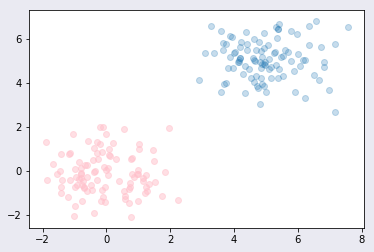

In [4]:
import numpy as np

#Example dataset
N_samples_per_class = 100
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),
               np.random.randn(N_samples_per_class, d_dimensions)
               +np.array([5,5])))
y = np.concatenate([-1.0*np.ones(N_samples_per_class),
              1.*np.ones(N_samples_per_class)])

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

In [5]:
import autograd.numpy as np
from autograd import grad

def SVM_predictions(w, inputs):
    return np.dot(w[0,:-1],inputs.T)+w[0,-1]

def SVM_training_loss(weights, inputs, targets):
    pred = SVM_predictions(weights, inputs)
    return np.sum(np.maximum(0,1-targets*pred))/inputs.shape[0]

def optimize(inputs, targets, training_loss):
    gradient_loss = grad(training_loss)
    weights = np.zeros((1,inputs.shape[1]+1))
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in np.arange(10000):
        weights -= gradient_loss(weights, inputs, targets) * 0.05
        if i%1000 == 0:
            print(" Loss:", training_loss(weights, inputs, targets))
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

weights = optimize(x, y, SVM_training_loss)
print("Weights", weights)

Initial loss: 1.0
 Loss: 0.4906032703365607
 Loss: 0.0036155374044994537
 Loss: 0.0027360916423485883
 Loss: 0.002464744440161455
 Loss: 0.0022112179091094484
 Loss: 0.001957343935506883
 Loss: 0.0017046682324205586
 Loss: 0.0014529675281935407
 Loss: 0.0012016828554032766
 Loss: 0.0009503981826130103
Final loss: 0.0006958211557364958
Weights [[ 0.48611924  0.64183999 -3.0605    ]]


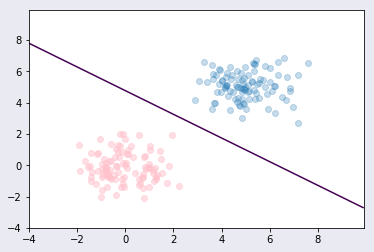

In [6]:
delta = 0.1
xx = np.arange(-4.0, 10.0, delta)
yy = np.arange(-4.0, 10.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = SVM_predictions(weights,test_data)

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
Z = np.reshape(Z,(xx.shape[0],xx.shape[0]))
plt.contour(XX,YY,Z,[0])
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

### Exercise 

+ Make the necessary changes to the code below in order to compute a new sample that is optimal for the classifier you have learned in the previous exercise. 

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


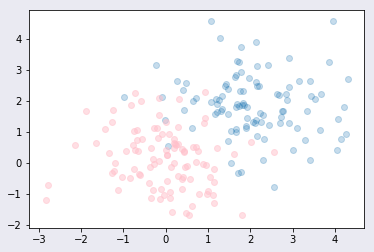

In [8]:
import numpy as np

#Example dataset
N_samples_per_class = 100
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),
               np.random.randn(N_samples_per_class, d_dimensions)
               +np.array([2,2])))
y = np.concatenate([-1.0*np.ones(N_samples_per_class),
              1.*np.ones(N_samples_per_class)])

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

In [9]:
import autograd.numpy as np
from autograd import grad

def SVM_predictions(w, inputs):
    return np.dot(w[0,:-1],inputs.T)+w[0,-1]

def SVM_training_loss(weights, inputs, targets):
    pred = SVM_predictions(weights, inputs)
    return np.sum(np.maximum(0,1-targets*pred))/inputs.shape[0]

def optimize(inputs, targets, training_loss):
    gradient_loss = grad(training_loss)
    weights = np.zeros((1,inputs.shape[1]+1))
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in np.arange(10000):
        weights -= gradient_loss(weights, inputs, targets) * 0.05
        if i%1000 == 0:
            print(" Loss:", training_loss(weights, inputs, targets))
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

weights = optimize(x, y, SVM_training_loss)
print("Weights", weights)

Initial loss: 1.0
 Loss: 0.9083343006590997
 Loss: 0.15850382884950484
 Loss: 0.15616469969812372
 Loss: 0.1560766773171379
 Loss: 0.15602832039596978
 Loss: 0.1559788616833424
 Loss: 0.15595695295322146
 Loss: 0.1559570972420523
 Loss: 0.15595597203509862
 Loss: 0.15595571761984117
Final loss: 0.1559552302298749
Weights [[ 1.52086827  1.20782654 -2.5915    ]]


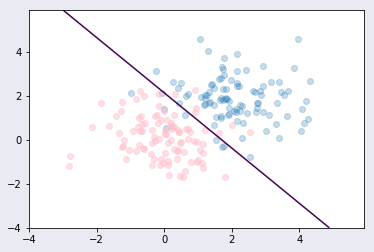

In [10]:
delta = 0.1
xx = np.arange(-4.0, 6.0, delta)
yy = np.arange(-4.0, 6.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = SVM_predictions(weights,test_data)

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
Z = np.reshape(Z,(xx.shape[0],xx.shape[0]))
plt.contour(XX,YY,Z,[0])
idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.25)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

In [11]:
# your code here


## Neural Network

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


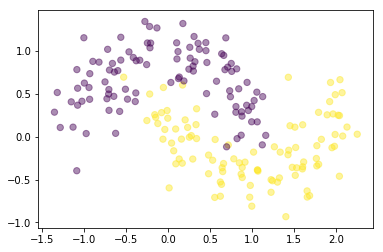

In [13]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function(s). If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \mbox{tanh}(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ a_2 = \mbox{softmax}({z_2})$$

$W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

A common choice with the softmax output is the cross-entropy loss. If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

In [14]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = np.dot(x,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

This is a version that solves the optimization problem by using the backpropagation algorithm (hand-coded derivatives):

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068898
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

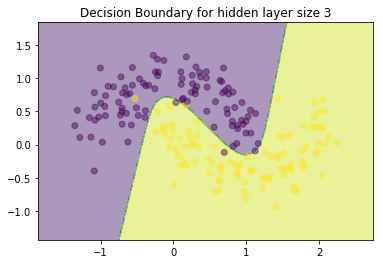

In [15]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in np.arange(0, num_passes):

        # Forward propagation
        z1 = np.dot(X,W1) + b1
        a1 = np.tanh(z1)
        z2 = np.dot(a1,W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

The next version solves the optimization problem by using AD:

/home/juan/anaconda3/envs/ks_dl_course/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Loss after iteration 0: 0.578766
Loss after iteration 1000: 0.289271
Loss after iteration 2000: 0.233985
Loss after iteration 3000: 0.183354
Loss after iteration 4000: 0.148689
Loss after iteration 5000: 0.120565
Loss after iteration 6000: 0.102844
Loss after iteration 7000: 0.091903
Loss after iteration 8000: 0.085048
Loss after iteration 9000: 0.080741
Loss after iteration 10000: 0.077962
Loss after iteration 11000: 0.076086
Loss after iteration 12000: 0.074758
Loss after iteration 13000: 0.073776
Loss after iteration 14000: 0.073021
Loss after iteration 15000: 0.072423
Loss after iteration 16000: 0.071936
Loss after iteration 17000: 0.071532
Loss after iteration 18000: 0.071192
Loss after iteration 19000: 0.070900


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

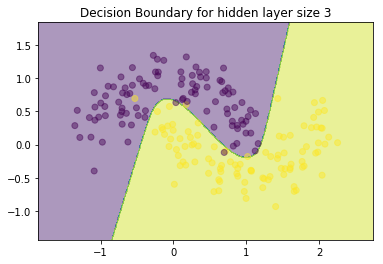

In [16]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in np.arange(0, num_passes):

        # Forward propagation
        z1 = np.dot(X,model['W1']) + model['b1']
        a1 = np.tanh(z1)
        z2 = np.dot(a1,model['W2']) + model['b2']
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
                
        gradient_loss = grad(calculate_loss)
        
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        model_flat -= grad_flat * 0.05
        model = unflatten_m(model_flat)

        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Let's now get a sense of how varying the hidden layer size affects the result.

/home/juan/anaconda3/envs/ks_dl_course/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


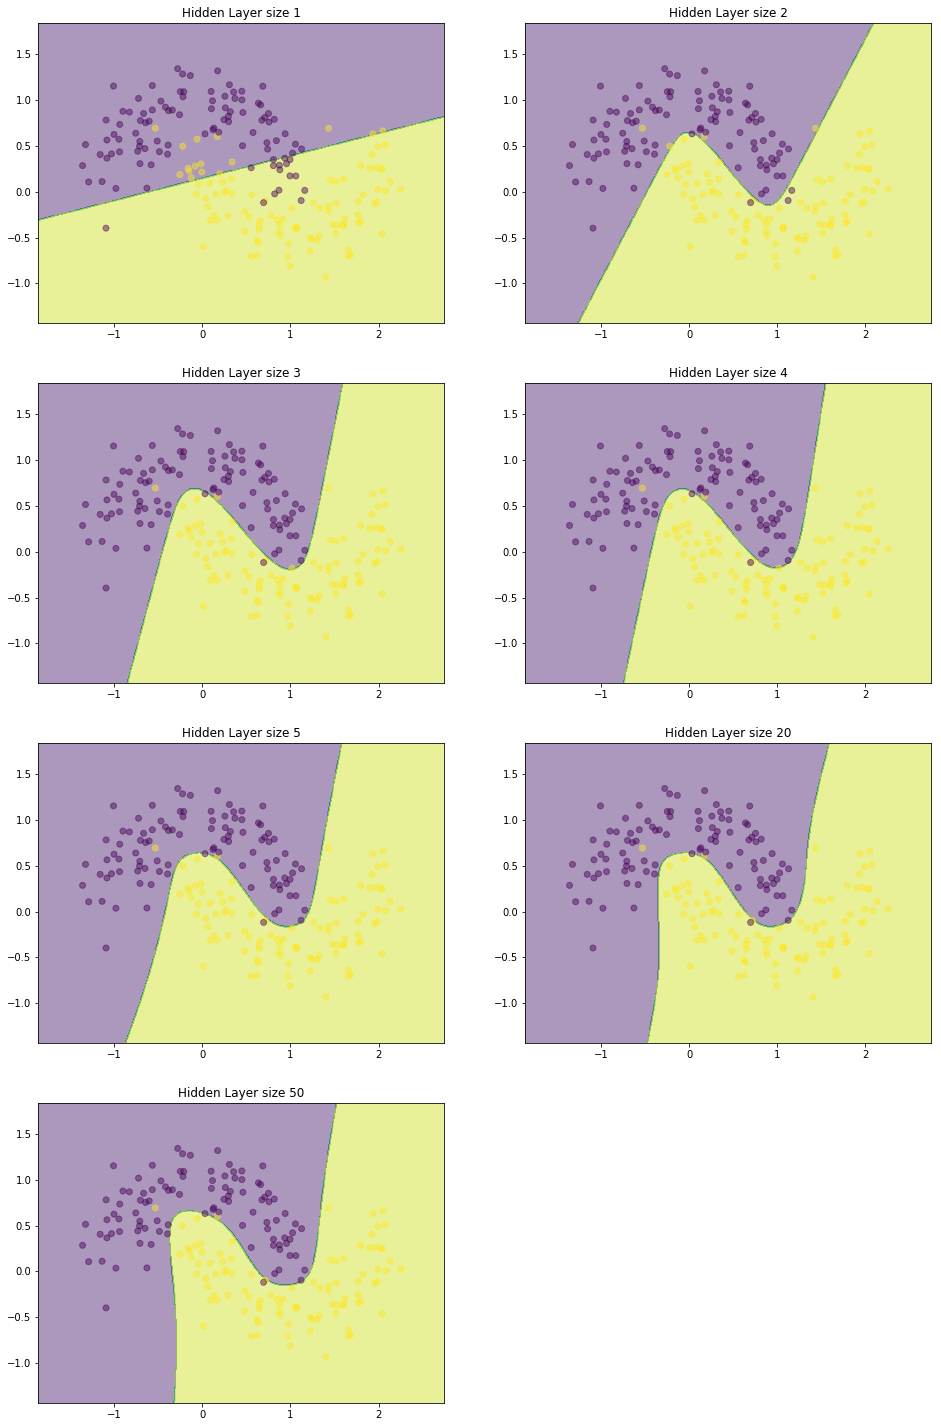

In [17]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

## Deep Learning tricks

### (We will see some of these in greater detail in another class, but you can get a glimpse of them here)

> A naïve description of the basic setup in deep learning would be: *a many-layers-deep network of linear layers, linear convolutions and occasionally recurrent structures with nonlinear activation functions that is trained by computing the gradient of the training error through reverse mode AD.*.

AD is a critical component when developing deep models because the use of SGD is much more easy and robust (f.e. derivative computation is free of bugs!), but in spite of this fact optimization of deep models is not yet an easy task. Gradient-based optimization still suffers from some problems:
+ The system can be poorly conditioned (changing one parameter requires precise compensatory changes to other parameters to avoid large increases in the optimization criterion). 
+ Simply calculating the actual gradient is so slow in deep learning systems that it is impractical to use the true
gradient for purposes of optimization.

In order to address each issues, deep learning community has developed some **tricks**. First, gradient tricks, namely methods to make the gradient either easier to calculate or to give it more desirable properties. And second, optimization tricks, namely new methods related to stochastic optimization.

The deep learning community has been developing many methods to make gradient descent work with deep architectures. These methods (related to model architectures and gradient calculation) are  numerous. Here we discuss only a small sample of methods.

+ It is not really feasible to calculate the true gradient when there is a large dataset.  Instead a sample is used. Calculating the gradient of the error of just a random sample from the dataset (or sequential windows, assuming the dataset has been randomly shuffled) is much faster.
+ In calculating the stochastic gradient, it is tempting to do the minimal amount of computation necessary to obtain an unbiased estimate, which would involve a single sample from the training set. In practice it has proven much better to use a block of contiguous samples, on the order of dozens.  This has two advantages: the first is less noise, and the second is that data-parallelism can be used.
+ In a multi-layered structure, one would expect the gradients of quantities at early layers to be nearly zero (assuming the gains at intermediate levels are below unity) or to be enormous (assuming the gains are above unity). The tricks are:
    + Rectified linear units instead of sigmoids. Classic multi-layer perceptrons use the sigmoid activation function, but this has a derivative which goes to zero when its input is too strong.  That means that when a unit in the network receives a very strong signal, it becomes difficult to change. Using a rectified linear unit (ReLU) function, overcomes this problem, making the system more plastic even when strong signals are present.
    + Gradient clipping. In the domain of deep learning, there are often outliers in the training set: exemplars that are being classified incorrectly, for example, or improper images in a visual classification task, or mislabeled examples, and the like. These can cause a large gradient inside a single mini-batch, which washes out the more appropriate signals. For this reason a technique called gradient clipping is often used, in which components of the gradient exceeding a threshold (in absolute value) are pushed down to that threshold.
+ Keeping the error surface well conditioned for gradient optimization has been one of the keys to the current widespread deployment of deep learning.
    + Dropout. Imagine a network in which multiple units together represent some important feature, requiring a precise weighting of their values in downstream processing. This would make optimization quite difficult, as it sets up couplings between parameters which must be maintained. A technique to avoid such “unfortunate collusions” is dropout, in which each unit in the network is, on each training pattern pass, randomly “dropped out” with some probability (typically 50%) by holding its value at zero. This encourages detected features to be independently meaningful. (In “production mode” dropout is turned off, and the weights scaled to compensate, to minimize the noise when performance matters.)
    + Batch normalization. Batch Normalization is a technique to provide any layer in a neural network with inputs that are zero mean/unit variance. 
    + Careful initialization. Considering how the variances of activation values and gradients can be maintained between the layers in a network leads to intelligent normalized initialization schemes, which enable substantially faster optimization convergence. 
+ Early stopping. When fitting a dynamic system to data, as exact a match as possible is desired, so the true optimum is sought. This is not the case in machine learning, where the optimization is of error on a training set, while the primary concern is generally not performance on the training set, but on as-yet-unseen new data. There is often a tradeoff between the two, encountered after optimization has proceeded for a significant amount of time. This is addressed by early stopping, in which an estimate of performance on unseen data is maintained, and optimization is halted early when this estimated generalization performance stops improving, even if performance on the training set is continuing to improve. 


